In [1]:
import time
t1 = time.time()
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')
import monod
from monod import analysis
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# dir_string = './fits/gg_230316_026_brain_nuc_4_1'


In [3]:
dataset_meta_sc = [f'brain_10x_30k_{i}' for i in range(1,5)]
dataset_meta_sn = [f'brain_nuc_10x_30k_{i}' for i in range(1,5)]
pair_ind = 3
dataset_names= [dataset_meta_sc[pair_ind],dataset_meta_sn[pair_ind]]
n_datasets = len(dataset_names)


In [4]:
dir_string = './fits/gg_230316_026_brain_nuc_4_1'
dataset_strings = [dir_string + '/' + x for x in dataset_names]
# result_strings = [dir_string + '/'+x+'/Bursty_Poisson_10x11/grid_scan_results_upd.res' for x in dataset_names]
result_strings = [dir_string + '/'+x+'/Bursty_Poisson_20x21/grid_scan_results_upd.res' for x in dataset_names]


In [5]:
sd_arr = [monod.analysis.load_search_data(x+'/raw.sd') for x in dataset_strings]


In [6]:
def plot_stat(X,Y,stat,ax1,modality='spliced',plot_offset=True):
    if stat=='mean':
        stat_fun = lambda x: x.mean(1)
    elif stat=='CV2':
        stat_fun = lambda x: (x.var(1))/(x.mean(1)**2)
    
    x = stat_fun(X)
    y = stat_fun(Y)
    gf = (~np.isnan(x)) & (~np.isnan(y)) & (x>0) & (y>0)
    x = x[gf]
    y = y[gf]
    ax1.scatter(x,y,1,'k',alpha=0.3)
    xl = np.linspace(x.min(),x.max())
    ax1.plot(xl,xl,'--',color='crimson',linewidth=4)
    if plot_offset:
        offset = y.mean()/x.mean()
        print('Offset: {:.2f}'.format(np.log10(offset)))
        ax1.plot(xl,xl*offset,color='lightseagreen',linewidth=2)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel('single-cell {} {}'.format(stat,modality))
    ax1.set_ylabel('single-nucleus {} {}'.format(stat,modality))


Offset: 0.08
Offset: -0.15
Offset: 0.51
Offset: -0.31


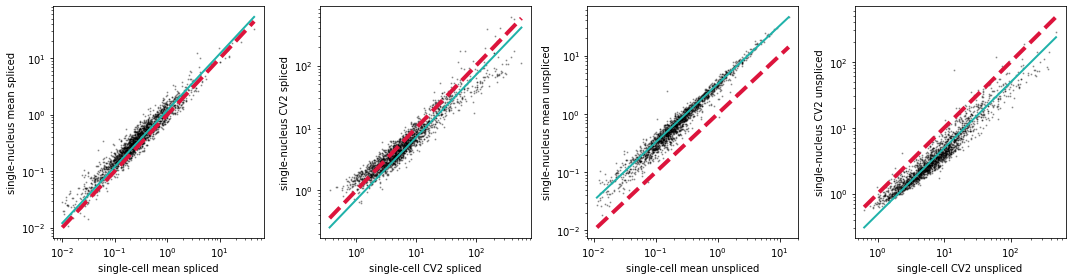

In [7]:
fig1,ax1=plt.subplots(1,4,figsize=(15,4))
plot_stat(sd_arr[0].layers[1],sd_arr[1].layers[1],'mean',ax1[0],'spliced')
plot_stat(sd_arr[0].layers[1],sd_arr[1].layers[1],'CV2',ax1[1],'spliced')
plot_stat(sd_arr[0].layers[0],sd_arr[1].layers[0],'mean',ax1[2],'unspliced')
plot_stat(sd_arr[0].layers[0],sd_arr[1].layers[0],'CV2',ax1[3],'unspliced')
fig1.tight_layout()


In [8]:
sr_arr = [monod.analysis.load_search_results(x) for x in result_strings]

In [9]:
from matplotlib.colors import ListedColormap

c1 = [173/255,214/255,200/255]
c2 = [59/255,131/255,130/255]
ncol=50
cmap_histogram = ListedColormap(np.array([np.linspace(c2[j],c1[j],ncol) for j in range(3)]).T)

def plot_landscape(sr,ax):
    x_ = np.unique(sr.sp.X)
    y_ = np.unique(sr.sp.Y)
    nX = len(x_)
    nY = len(y_)
    X,Y = np.meshgrid(x_,y_,indexing='ij')
    kld = np.reshape(np.log10(sr.klds.sum(1)),sr.sp.gridsize)
#     print(kld)
    vmin = kld.min()
    vmax = kld.max()
    ax.pcolormesh(X,Y,(kld),cmap=cmap_histogram,vmin=vmin,vmax=vmax)
    q = np.quantile(kld,0.05)
    ax.pcolor(X,Y,np.ma.masked_array(kld,kld>q),
                  cmap=cmap_histogram,
                  alpha=1,hatch='///',edgecolor='darkorange',facecolor=None,linewidth=0,
                  vmin=vmin,vmax=vmax)

    #     print(kld.shape)
#     print(X.shape)
    # logL_2d = np.zeros((nX,nY))


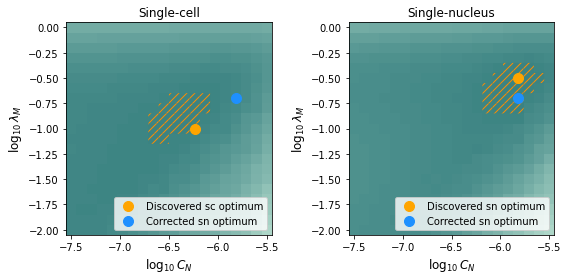

In [10]:
fs=12
fig1,ax1= plt.subplots(1,2,figsize=(8,4))
names = ['Single-cell','Single-nucleus']
abbr_names = ['sc','sn']
arbitrary_v3_params = np.asarray(sr_arr[0].samp_optimum)+0.5
arbitrary_v3_ind = np.argmin(((sr_arr[1].param_estimates[:,~sr_arr[0].rejected_genes,:] - sr_arr[0].phys_optimum[~sr_arr[0].rejected_genes])**2)[:,:,:2].sum((1,2)))
arbitrary_v3_pars = sr_arr[1].sp.sampl_vals[arbitrary_v3_ind]
for k in range(2):
    plot_landscape(sr_arr[k],ax1[k])
    ax1[k].scatter(sr_arr[k].samp_optimum[0],sr_arr[k].samp_optimum[1],100,c='orange',label='Discovered {} optimum'.format(abbr_names[k]))
    ax1[k].scatter(arbitrary_v3_pars[0],arbitrary_v3_pars[1],100,c='dodgerblue',label='Corrected sn optimum')
    ax1[k].set_xlabel(r'$\log_{10} C_N$',fontsize=fs)
    ax1[k].set_ylabel(r'$\log_{10} \lambda_M$',fontsize=fs)
    ax1[k].set_title(names[k],fontsize=fs)
    ax1[k].legend(loc='lower right')
fig1.tight_layout()
plt.savefig('./figs/brain_nuc_landscape.png',dpi=450)
plt.savefig('./figs/brain_nuc_landscape.pdf')

(-6.2368421052631575, -1.0)
(-5.815789473684211, -0.7)
0.917875784358617
0.9716839230179558
0.9490974665803152


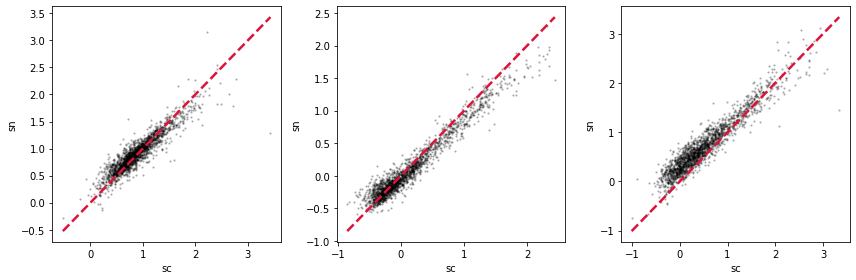

In [12]:
fig1,ax1 = plt.subplots(1,3,figsize=(12,4))
# arbitrary_v3_params = np.asarray(sr_arr[0].samp_optimum)+0.5
arbitrary_v3_ind = np.argmin(((sr_arr[1].param_estimates[:,~sr_arr[0].rejected_genes,:] - sr_arr[0].phys_optimum[~sr_arr[0].rejected_genes])**2)[:,:,:2].sum((1,2)))
sr_arr[1].set_sampling_optimum(arbitrary_v3_ind)
_=sr_arr[1].chisquare_testing(sd_arr[1],threshold=0.01)
gf = (~sr_arr[1].rejected_genes)&(~sr_arr[0].rejected_genes)

print(sr_arr[0].samp_optimum)
print(sr_arr[1].samp_optimum)
for j in range(3):
    x = sr_arr[0].phys_optimum[gf,j]
    y = sr_arr[1].phys_optimum[gf,j]
    print(np.corrcoef(x,y)[0,1])
    ax1[j].scatter(x,y,2,'k',alpha=0.2)
    xl = np.linspace(min(x),max(x))
    ax1[j].plot(xl,xl,'--',color='crimson',linewidth=2.5)
    ax1[j].set_xlabel('sc')
    ax1[j].set_ylabel('sn')
fig1.tight_layout()

In [ ]:
sr_arr[1].compute_sigma(sd_arr[1],num_cores=15)

## Fig 4 b-h

In [13]:
c_genes = 'dimgrey'
alpha_genes = 0.1
c_highlight = 'tomato'
alpha_highlight = 0.7
c_baseline = np.asarray([9,160,115])/255
c_singlegene = 'dodgerblue'
ms_genes = 20
ms_highlight = 20
fs_axes = 12
fs_title=14
alpha_line = 0.48
lw = 3
# c_baseline_violation = 'blueviolet'
c_identity = 'k'
names = ['Single-cell','Single-nucleus']

In [20]:
def plot_stat_simplified(X,Y,stat,ax1,modality='spliced',plot_offset=True):
    if stat=='mean':
        stat_fun = lambda x: x.mean(1)
    elif stat=='CV2':
        stat_fun = lambda x: (x.var(1))/(x.mean(1)**2)
    
    x = stat_fun(X)
    y = stat_fun(Y)
    gf = (~np.isnan(x)) & (~np.isnan(y)) & (x>0) & (y>0)
    x = x[gf]
    y = y[gf]
    print((y>x).mean())
    ax1.scatter(x,y,ms_genes,c_genes,alpha=alpha_genes,label='Genes')
    xl = np.linspace(x.min(),x.max())
    ax1.plot(xl,xl,'--',color=c_identity,linewidth=lw,label='Identity')
    if plot_offset:
        offset = y.mean()/x.mean()
#         print('Offset: {:.2f}'.format(np.log10(offset)))
        ax1.plot(xl,xl*offset,color='mediumseagreen',linewidth=lw,label='Offset fit')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
#     ax1.set_xlabel('single-cell {} {}'.format(stat,modality))
#     ax1.set_ylabel('single-nucleus {} {}'.format(stat,modality))


0.83
0.999
0.338
0.0165


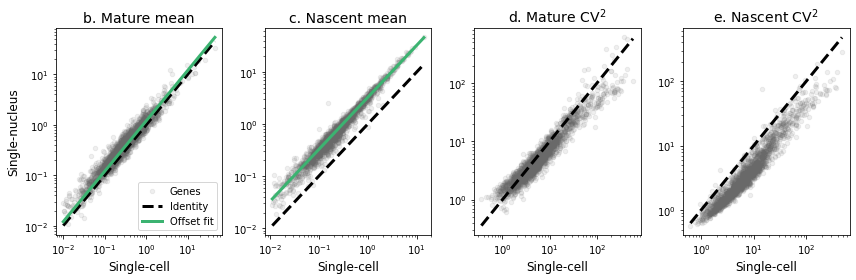

In [21]:
fig1,ax1 = plt.subplots(1,4,figsize=(12,4))

plot_stat_simplified(sd_arr[0].layers[1],sd_arr[1].layers[1],'mean',ax1[0],'spliced')
plot_stat_simplified(sd_arr[0].layers[0],sd_arr[1].layers[0],'mean',ax1[1],'unspliced')
plot_stat_simplified(sd_arr[0].layers[1],sd_arr[1].layers[1],'CV2',ax1[2],'spliced',plot_offset=False)
plot_stat_simplified(sd_arr[0].layers[0],sd_arr[1].layers[0],'CV2',ax1[3],'unspliced',plot_offset=False)

ax1[0].set_ylabel(names[1],fontsize=fs_axes)
ax1[0].legend(loc='lower right')
for ax in ax1:
    ax.set_xlabel(names[0],fontsize=fs_axes)
ax1[0].set_title('b. Mature mean',fontsize=fs_title)
ax1[1].set_title('c. Nascent mean',fontsize=fs_title)
ax1[2].set_title('d. Mature CV$^2$',fontsize=fs_title)
ax1[3].set_title('e. Nascent CV$^2$',fontsize=fs_title)

fig1.tight_layout()
plt.savefig('./figs/fig4b_e.png',dpi=450)
plt.savefig('./figs/fig4b_e.pdf')

In [172]:
import scipy

(-6.2368421052631575, -1.0)
(-5.815789473684211, -0.7)
Ttest_indResult(statistic=-2.684876539425132, pvalue=0.007287248972746062)
0.917875784358617
Ttest_indResult(statistic=1.5993453940280415, pvalue=0.10982723112971107)
0.9716839230179558
Ttest_indResult(statistic=-10.930513710632885, pvalue=2.1041229008780283e-27)
0.9490974665803152


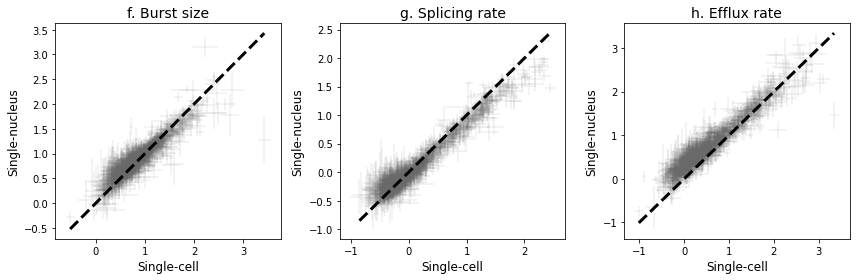

In [186]:
fig1,ax1 = plt.subplots(1,3,figsize=(12,4))
# arbitrary_v3_params = np.asarray(sr_arr[0].samp_optimum)+0.5
# arbitrary_v3_ind = np.argmin(((sr_arr[1].param_estimates[:,~sr_arr[0].rejected_genes,:] - sr_arr[0].phys_optimum[~sr_arr[0].rejected_genes])**2)[:,:,:2].sum((1,2)))
# sr_arr[1].set_sampling_optimum(arbitrary_v3_ind)
# _=sr_arr[1].chisquare_testing(sd_arr[1],threshold=0.01)
gf = (~sr_arr[1].rejected_genes)&(~sr_arr[0].rejected_genes)
c=2.576
print(sr_arr[0].samp_optimum)
print(sr_arr[1].samp_optimum)
for j in range(3):
    x = sr_arr[0].phys_optimum[gf,j]
    y = sr_arr[1].phys_optimum[gf,j]
    dx = sr_arr[0].sigma[gf,j]*c
    dy = sr_arr[1].sigma[gf,j]*c
    print(scipy.stats.ttest_ind(x,y))
    print(np.corrcoef(x,y)[0,1])
    ax1[j].errorbar(x,y,dx,dy,c=c_genes,linestyle="None",alpha=alpha_genes)

    xl = np.linspace(min(x),max(x))
    ax1[j].plot(xl,xl,'--',color=c_identity,linewidth=lw)
    ax1[j].set_xlabel(names[0],fontsize=fs_axes)
    ax1[j].set_ylabel(names[1],fontsize=fs_axes)
ax1[0].set_title('f. Burst size',fontsize=fs_title)
ax1[1].set_title('g. Splicing rate',fontsize=fs_title)
ax1[2].set_title('h. Efflux rate',fontsize=fs_title)
fig1.tight_layout()
plt.savefig('./figs/fig4f_h.png',dpi=450)
plt.savefig('./figs/fig4f_h.pdf')